In [ ]:
import torch
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from abc import ABC, abstractmethod
from math import comb

In [ ]:
plt.rc('font', family='serif')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"currently running device : {device}")

currently running device : cuda


In [ ]:
class SpinChain:
  def __init__(self,n : int, device : str = device) -> None:
    self.n = n
    self.device = device

    self.Jz = self.get_Jz()
    self.J2 = self.get_J2()
    self.Jplus, self.Jminus = self.get_Jpm()

    self.Jx = (self.Jplus + self.Jminus) / 2
    self.Jy = (self.Jplus - self.Jminus) / (2 * 1j)

  def get_Jz(self) -> torch.tensor:

    diagonal = torch.tensor(
        [k - self.n / 2 for k in range(self.n + 1)],
        dtype = torch.complex64,
        device = self.device
        )

    return torch.diag(diagonal)

  def get_Jpm(self) -> torch.tensor:

    diagonal_plus = torch.tensor(
        [np.sqrt((self.n-k) * (k+1)) for k in range(self.n)],
        dtype = torch.complex64,
        device = self.device
        )

    diagonal_minus = torch.tensor(
        [np.sqrt((k) * (self.n - k +1)) for k in range(1,self.n+1)],
        dtype = torch.complex64,
        device = self.device
        )

    Jp = torch.diag(diagonal_plus, diagonal = 1)
    Jm = torch.diag(diagonal_minus, diagonal = -1)

    return Jp,Jm

  def get_J2(self) -> torch.tensor:
    return torch.eye(
        self.n + 1,
        dtype = torch.complex64,
        device = self.device) * ((self.n/2) * (self.n/2 + 1))


In [ ]:
class Operators:
  def __init__(self, device : str = device) -> None:
    self.device = device
    self.get_all()

  def get_all(self):
    self.sigma_x = torch.tensor([[0, 1],[-1,0]], dtype = torch.complex64, device = self.device)
    self.sigma_y = torch.tensor([[0, -1j],[1j,0]], dtype = torch.complex64, device = self.device)
    self.sigma_z = torch.tensor([[1,0],[0,-1]], dtype = torch.complex64, device = self.device)
    self.Id = torch.tensor([[1,0],[0,1]], dtype = torch.complex64, device = self.device)

In [ ]:
class NewKickedTop:
  def __init__(self, n : int, alpha : float, beta : float = np.pi/2, device : str = device) -> None:
    self.n = n
    self.device = device

    self.SpinModel = SpinChain(n-1,self.device)
    self.operators = Operators(device = device)

    self.U1, self.U2 = self.getEvolutionOperators(alpha , beta = beta)
    self.U = self.U1 @ self.U2

  def getEvolutionOperators(self, alpha : float , beta : float = np.pi/2) -> tuple:
    Jz = self.SpinModel.Jz
    Jy = self.SpinModel.Jy

    H1 = torch.kron(self.operators.Id,Jz) + torch.kron(self.operators.sigma_z, torch.eye(self.n, dtype = torch.complex64, device = self.device))
    H1 = H1 @ H1
    H2 = torch.kron(self.operators.Id,Jy) + torch.kron(self.operators.sigma_y, torch.eye(self.n, dtype = torch.complex64, device = self.device))

    E1, V1 = torch.linalg.eigh(H1)
    E2, V2 = torch.linalg.eigh(H2)

    U1 = V1 @ torch.exp(1j * alpha / (self.n) * E1).diag() @ V1.conj().T
    U2 = V2 @ torch.exp(1j * beta * E2).diag() @ V2.conj().T

    return U1, U2

  def Perturbation(self, m : list, phi : float) -> torch.tensor:
    suma = sum(x**2 for x in m)
    assert suma > (1 - 1e-4) and suma < (1 + 1e-4) and len(m) == 3, "vector not normalized"

    m1, m2, m3 = m

    J = m1 * self.SpinModel.Jx + m2 * self.SpinModel.Jy + m3 * self.SpinModel.Jz
    E, V = torch.linalg.eigh(J)

    S = m1 * self.operators.sigma_x + m2 * self.operators.sigma_y + m3 * self.operators.sigma_z
    sE, sV = torch.linalg.eigh(S)

    u1 = V @ torch.exp(1j * E * phi / 2).diag() @ V.conj().T
    u2 = sV @ torch.exp(1j * sE * phi / 2).diag() @ sV.conj().T

    return torch.kron(u1,u2)

  def make_step(self, rho : torch.tensor) -> torch.tensor:
    rho_red = rho[:self.n,:self.n] + rho[self.n:,self.n:]
    rho = torch.kron(self.operators.Id/2, rho_red)
    return self.U @ rho @ self.U.conj().T

In [ ]:
class Reductor:
  def __init__(self, n : int, device : str = device) -> None:
    self.n = n
    self.red00 = torch.tensor([(n - l) / n for l in range(self.n)], dtype = torch.complex64, device = device)
    self.red10 = torch.tensor([np.sqrt((n - l)*(l+1)) / n for l in range(self.n)], dtype = torch.complex64, device = device)
    self.red11 = torch.tensor([(l + 1) / n for l in range(self.n)], dtype = torch.complex64, device = device)
    self.red01 = self.red10

In [ ]:
class Drive_Simulation:
  def __init__(self, n : int, alpha : float, beta : float = np.pi/2, device : str = device):
    self.n = n
    self.device = device
    self.model = NewKickedTop(n,alpha,beta = beta,device = device)
    self.reductor = Reductor(self.n-1,device = device)
    print("device ready")

  def PrepareInitialState(self, theta : float, phi : float) -> torch.tensor:
    st = [np.sqrt(float(comb(self.n-1,k))) * np.cos(theta)**(self.n-1 - k) * np.sin(theta)**(k) * np.exp(1j * phi * (self.n-1-k)) for k in range(self.n) ]
    st = torch.tensor(st, dtype = torch.complex64, device = self.device)

    st_q = torch.tensor([1,0],dtype = torch.complex64, device = self.device)
    st = torch.kron(st_q,st)
    return torch.kron(st.reshape(-1,1),st.reshape(1,-1).conj())

  def run(self,steps : int = 64, sample_size : int = 10, m : list = [0,1,0], phi : float = 0.01):
    th, phi = self.random_points_sphere(sample_size)
    U3 = self.model.Perturbation(m,0.01)
    states = [self.PrepareInitialState(theta,phi_) for theta, phi_ in zip(th,phi)]
    perturbed_states = [U3 @ rho_ @ U3.conj().T for rho_ in states]

    print(f"number of states inside the sample: {len(states)}")

    dist_, lin_S = self.AvgPerStep(states,perturbed_states)
    print(f"initial distnce : {dist_}, linear entropy : {lin_S}")
    distance = [dist_]
    linear_S = [lin_S]
    for _ in range(steps):
      dist_, lin_S = self.AvgPerStep(states,perturbed_states)
      distance.append(dist_)
      linear_S.append(lin_S)
    return distance, linear_S

  def AvgPerStep(self, states : list , perturbed_states : list) -> tuple:
    dist = 0
    lin_entropy = 0
    for i, st in enumerate(states):
      states[i] = self.model.make_step(states[i])
      perturbed_states[i] = self.model.make_step(perturbed_states[i])
      dist_, lin_entropy_ =  self.CalcPerStep(states[i],perturbed_states[i])
      dist += dist_
      lin_entropy += lin_entropy_
    return dist / len(states), lin_entropy / len(states)

  def reduce_first_spin(self,rho : torch.tensor) -> torch.tensor:
    return rho[:self.n,:self.n] + rho[self.n:,self.n:]

  def CalcPerStep(self,rho : torch.tensor,rho_p : torch.tensor) -> float :
    rho_reduced_1 = self.reduce_first_spin(rho)
    rho_p_reduced_1 = self.reduce_first_spin(rho_p)
    rho_red = self.reduce(rho_reduced_1)
    rho_p_red = self.reduce(rho_p_reduced_1)
    E = torch.linalg.eigvals((rho_red - rho_p_red))
    return E.abs().sum().item() * self.n / 2 , 1 - (rho_red @ rho_red).trace().item()

  def reduce(self, rho : torch.tensor) -> torch.tensor:
    rho00 = rho.diag()[:-1] @ self.reductor.red00
    rho01 = rho.diag(diagonal = 1) @ self.reductor.red01
    rho11 = rho.diag()[1:] @ self.reductor.red11
    return torch.tensor([[rho00,rho01],[rho01.conj(), rho11]], dtype = torch.complex64, device = self.device)

  def random_points_sphere(self, n : int, seed : int = 42) -> np.ndarray:
    rng_th = np.random.default_rng(seed = seed)
    rng_mc =  np.random.default_rng(seed = seed + 20)
    rng_phi = np.random.default_rng(seed = seed + 10)

    th = rng_th.uniform(size = n) * np.pi
    mc_decide = rng_mc.uniform(size = n)
    th = th[np.where(np.sin(th) > mc_decide, True,False)]

    phi = rng_phi.uniform(size = len(th)) * 2 * np.pi

    return th, phi


In [ ]:
rng = np.random.default_rng(seed = 42)
m1 = rng.uniform()
m2 = rng.uniform() * np.sqrt(1-m1**2)
m3 = np.sqrt(1- m1**2 - m2**2)
m = [m1,m2,m3]

In [ ]:
als = [i for i in range(1,10)]
dists = []
lin_S = []

for al in als:
  simulation_1 = Drive_Simulation(10,al)
  dist1, lin_S1 = simulation_1.run(steps = 60,sample_size = 160, m = m)
  dists.append(dist1)
  lin_S.append(lin_S1)

device ready
number of states inside the sample: 104
initial distnce : 0.023729446872424047, linear entropy : (0.03612035512924194+9.178771703703787e-10j)
device ready
number of states inside the sample: 104
initial distnce : 0.025704748287143257, linear entropy : (0.12450178884542905+1.5910243058922737e-09j)
device ready
number of states inside the sample: 104
initial distnce : 0.025646212721207682, linear entropy : (0.2220814382800689+3.0314315507604317e-10j)
device ready
number of states inside the sample: 104
initial distnce : 0.02281251728373508, linear entropy : (0.29494649114517063-9.199242180646596e-10j)
device ready
number of states inside the sample: 104
initial distnce : 0.017974397367372427, linear entropy : (0.3346273366075296+1.1061362467005371e-09j)
device ready
number of states inside the sample: 104
initial distnce : 0.01287945730487431, linear entropy : (0.35057750745461536-9.433942684203065e-10j)
device ready
number of states inside the sample: 104
initial distnce : 

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


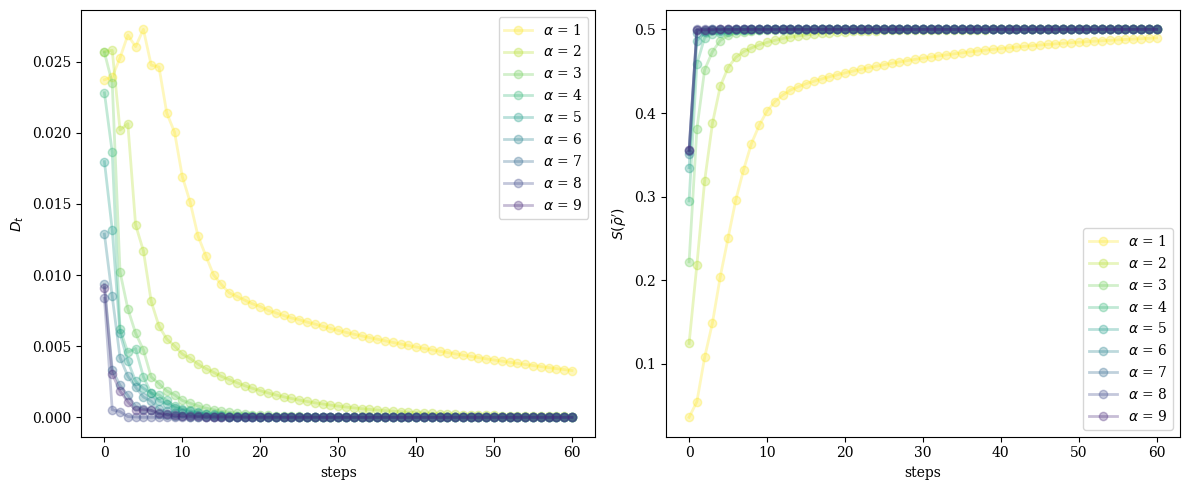

In [ ]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i, al in enumerate(als):
  ax1.plot(dists[i],color = cm.viridis(1 - i / len(als)),lw = 2, alpha = 0.3, label = r"$\alpha$" + " = " + str(al), marker = "o")
  ax2.plot(lin_S[i],color = cm.viridis(1 - i / len(als)),lw = 2, alpha = 0.3, label = r"$\alpha$" + " = " + str(al), marker = "o")
ax1.set_xlabel("steps")
ax1.set_ylabel(r"$D_{t}$")
ax1.legend()

ax2.set_xlabel("steps")
ax2.set_ylabel(r"$S(\bar{\rho}')$")
ax2.legend()

plt.tight_layout()

plt.show()